### Import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric 
from torch_geometric.datasets import GeometricShapes
from torch.utils.data import DataLoader
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import numpy as np
import torch_geometric.utils as pygutils
import dgl
from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx

from gnnexplainer.GNNExplainer import GNNExplainer
# from torch_geometric.nn import  GNNExplainer

Using backend: pytorch


In [2]:
import dgl.function as fn
import torch
import torch.nn as nn


# Sends a message of node feature h.
msg = fn.copy_src(src='h', out='m')

def reduce(nodes):
    """Take an average over all neighbor node features hu and use it to
    overwrite the original node feature."""
    accum = torch.mean(nodes.mailbox['m'], 1)
    return {'h': accum}

class NodeApplyModule(nn.Module):
    """Update the node feature hv with ReLU(Whv+b)."""
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}

class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        # Initialize the node features with h.
        g.ndata['h'] = feature
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')
import torch.nn.functional as F


class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()

        self.layers = nn.ModuleList([
            GCN(in_dim, hidden_dim, F.relu),
            GCN(hidden_dim, hidden_dim, F.relu)])
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # For undirected graphs, in_degree is the same as
        # out_degree.
        h = g.in_degrees().view(-1, 1).float().cuda()
        for conv in self.layers:
            h = conv(g, h)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

### Load Dataset

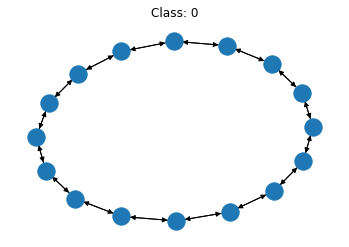

In [3]:

# A dataset with 80 samples, each graph is
# of size [10, 20]
trainset = MiniGCDataset(600, 12, 20)
testset = MiniGCDataset(60, 12, 20)
graph, label = trainset[55]
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()

### Net Definition

In [4]:
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

train_data_loader = DataLoader(trainset, batch_size=1, shuffle=True,collate_fn=collate)

traindata=[]
for iter, (g,label) in enumerate(train_data_loader):
    if(label == 5):
        traindata.append((g,0))
    if(label == 7):
        traindata.append((g,1)) 

In [5]:
class Net(torch.nn.Module):
    def __init__(self,in_dim, hidden_dim, n_classes):
        super(Net, self).__init__()
#         self.lin = Sequential(Linear(10, 10))
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, x, edge_index):
        h1 = F.relu(self.conv1(x, edge_index))
#         h2 = F.dropout(h1, training=self.training)
        h3 = F.relu(self.conv2(h1, edge_index))
        y = torch.mean(h3, 0, True)
        return self.classify(y)

### Training

In [6]:
training_epoch = 100 #original = 1500 for 1 training sample 500 for 20 samples
initial_lr = 0.0001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = 'explaingraph_epoch30005-May-2020-13:32:24'
SAVE_PATH = './models/' + model_name
model = Net(1, 256, 2).to(device)
optimizer = optim.Adam(model.parameters(), lr = initial_lr,weight_decay=5e-4)
# optimizer = optim.SGD(model.parameters(), lr = initial_lr, momentum=0.9, weight_decay=5e-4)
training = 'Continue'
if(training == 'New'):
    dateTimeObj = datetime.now()
    timestampStr = dateTimeObj.strftime("%d-%b-%Y-%H:%M:%S")
    model_name = 'explaingraph_epoch{}'.format(training_epoch)+timestampStr
if(training=='Continue'):
    checkpoint = torch.load(SAVE_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    # loss = checkpoint['loss']
    print(device)
    training=''

cuda


In [ ]:
import time
from datetime import datetime
model = Classifier(1, 256, 2).cuda()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

epoch_losses = []
#start timer:
t0 = time.time()
for epoch in range(training_epoch):
    model.train()
    epoch_loss = 0
    predictions=[]
    all_adjs =[]
    all_feats=[]
    all_labels=[]
    for iter, (g,label) in enumerate(traindata):
        x = g.in_degrees().view(-1, 1).float().to(device)
        
        adj = g.adjacency_matrix()
        adj_dense=adj.to_dense()
        if(iter == 0):
            prev_adjs = adj_dense

            prev_feats = x

            prev_labels = label
            all_adjs.append(prev_adjs)
            all_feats.append(prev_feats)
            all_labels.append(prev_labels)
        else:
            prev_adjs = adj_dense
            prev_feats = x
            prev_labels = label
            all_adjs.append(prev_adjs)
            all_feats.append(prev_feats)
            all_labels.append(prev_labels)
        a = g.edges()[0].tolist()
        b = g.edges()[1].tolist()
        edges = list(zip(a,b))
        edges = np.array(edges)
        edges = torch.LongTensor(edges.transpose()).to(device)
        labels = np.array([label])

        prediction = model(g)

        predictions += prediction.cpu().detach().numpy().tolist()
        
        loss = loss_func(prediction, torch.LongTensor(labels).cuda())
        optimizer.zero_grad()
        loss.backward()

        optimizer.step() 
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

training_time = time.time() - t0

print('Finished training. Training time = {:.4f} Seconds'.format(training_time))

cg_data = {
    "adj": all_adjs,
    "feat": all_feats,
    "label": all_labels,
    "pred": np.expand_dims(predictions, axis=0),
    "train_idx": list(range(len(traindata))),
}


SAVE_PATH = './models/' + model_name
torch.save({'epoch':epoch,
            'model_state_dict':model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            "cg": cg_data,
           }, SAVE_PATH)

plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

### Evalution

In [ ]:
test_data_loader=DataLoader(testset, batch_size=1, shuffle=False,collate_fn=collate)

test_data = []
for iter, (g,label) in enumerate(test_data_loader):
    if(label==5):
        test_data.append((g,0,iter))
    if(label==7):
        test_data.append((g,1,iter))
        
print(test_data)

In [ ]:
model.eval

prediction=torch.zeros(len(test_data),1,dtype=torch.float64)
for iter, (g,label,_) in enumerate(test_data):
        x = g.in_degrees().view(-1, 1).float().cuda()
        a = g.edges()[0].tolist()
        b = g.edges()[1].tolist()
        edges = list(zip(a,b))
        edges = np.array(edges)
        edges = torch.LongTensor(edges.transpose()).cuda()
        labels = np.array([label])

        pred = model(g)
        probs_Y = torch.softmax(pred, 1)
        argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
#         prediction[iter] = (argmax_Y.cuda()==label.cuda())
        prediction[iter] = (argmax_Y==label)
        print(probs_Y,argmax_Y,label)
        

In [ ]:
print('Accuracy of argmax predictions on the test set: {:.4f}%'.format(
    (prediction.cuda().sum().item() / len(test_data)) * 100))

### GNNExplainer

In [7]:
from gnnexplainer import explain

In [ ]:

i=20
idx=20
mask_name = 'masked_adj_{}.npy'.format(idx)
# graph_adj = traindata

adj = np.load(mask_name, allow_pickle=True)
fig, (ax1, ax2, ax4,ax5) = plt.subplots(1, 4, figsize=(20,5))

graph,label = graph_adj[i]

G = graph.to_networkx()
pos = nx.kamada_kawai_layout(G)

nx.draw(G,pos,ax=ax4)
# nx.draw_networkx_labels(G, pos,ax=ax4)
filt_adj = adj.copy()
filt_adj[adj<0.7] = 0
f = filt_adj
G = nx.from_numpy_array(f)

nx.draw(G,pos,ax=ax5)


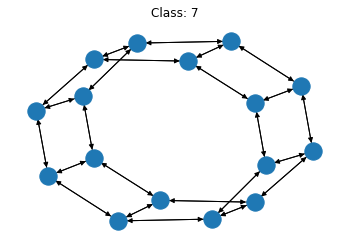

DGLGraph(num_nodes=16, num_edges=64,
         ndata_schemes={}
         edata_schemes={}) 7
[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[1, 8, 7, 0, 2, 9, 1, 3, 10, 2, 4, 11, 3, 5, 12, 4, 6, 13, 5, 7, 14, 6, 15, 0, 9, 0, 15, 8, 10, 1, 9, 11, 2, 10, 12, 3, 11, 13, 4, 12, 14, 5, 13, 15, 6, 14, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
tensor([[-1.3080,  1.2862]], device='cuda:0', grad_fn=<AddmmBackward>)


In [7]:
test_g,label = testset[55]

fig, ax = plt.subplots()
nx.draw(test_g.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()
print(test_g,label)
label = 0
x = test_g.in_degrees().view(-1, 1).float().cuda()
# x = feature
a = test_g.edges()[0].tolist()
print(a)

b = test_g.edges()[1].tolist()
print(b)
edges= list(zip(a,b))
edges=np.array(edges)
edges=torch.LongTensor(edges.transpose()).cuda()
probs_Y = model(x, edges)
print(probs_Y)

from tensorboardX import SummaryWriter
writer = SummaryWriter()
explainer = GNNExplainer(model, epochs=400,lr=0.1,writer=writer)

tensor(1., device='cuda:0')
tensor([1.], device='cuda:0')
tensor(1., device='cuda:0')
tensor([1.], device='cuda:0')
tensor(1., device='cuda:0')
tensor([1.], device='cuda:0')
tensor(1., device='cuda:0')
tensor([1.], device='cuda:0')
tensor(1., device='cuda:0')
tensor([1.], device='cuda:0')
tensor(1., device='cuda:0')
tensor([1.], device='cuda:0')
tensor(1., device='cuda:0')
tensor([1.], device='cuda:0')
tensor(1., device='cuda:0')
tensor([1.], device='cuda:0')
tensor(1., device='cuda:0')
tensor([1.], device='cuda:0')
tensor(1., device='cuda:0')
tensor([1.], device='cuda:0')
tensor(1., device='cuda:0')
tensor([1.], device='cuda:0')
tensor(1., device='cuda:0')
tensor([1.], device='cuda:0')
tensor(1., device='cuda:0')
tensor([1.], device='cuda:0')
tensor(1., device='cuda:0')
tensor([1.], device='cuda:0')
tensor(1., device='cuda:0')
tensor([1.], device='cuda:0')
tensor(1., device='cuda:0')
tensor([1.], device='cuda:0')
tensor(1., device='cuda:0')
tensor([1.], device='cuda:0')
tensor(1., dev

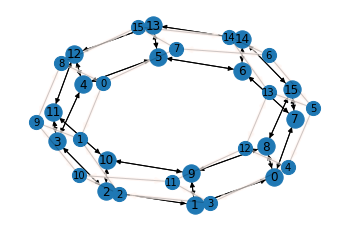

In [8]:
from math import sqrt

import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from torch_geometric.utils import k_hop_subgraph, to_networkx
import numpy as np
EPS = 1e-15

fig, ax = plt.subplots()
G=test_g.to_networkx()
pos = nx.spring_layout(G)
nx.draw(G,pos,ax=ax)
# nx.draw_networkx_nodes(G, pos,ax=ax)
nx.draw_networkx_labels(G, pos)

edge_mask,node_feat_mask,epoch_losses = explainer.explain_graph(x=x, edge_index=edges)

plt = explainer.visualize_subgraph(None,edge_index=edges, edge_mask=edge_mask,threshold=0.1)
plt.show()



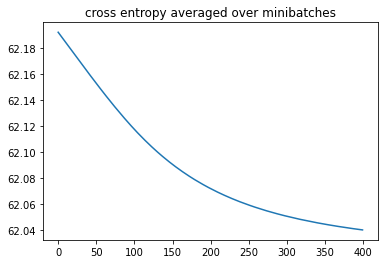

tensor([0.0672, 0.0489, 0.0368, 0.0591, 0.0444, 0.0469, 0.0606, 0.0460, 0.0657,
        0.0586, 0.0520, 0.0725, 0.0440, 0.0556, 0.0440, 0.0497, 0.0659, 0.0486,
        0.0448, 0.0632, 0.0612, 0.0587, 0.0462, 0.0524, 0.0643, 0.0483, 0.0486,
        0.0654, 0.0647, 0.0505, 0.0722, 0.0794, 0.0443, 0.0620, 0.0444, 0.0585,
        0.0353, 0.0410, 0.0404, 0.0569, 0.0588, 0.0614, 0.0661, 0.0498, 0.0519,
        0.0728, 0.0508, 0.0526, 0.0818, 0.0476, 0.0603, 0.0573, 0.0622, 0.0619,
        0.0616, 0.0338, 0.0675, 0.0485, 0.0583, 0.0661, 0.0437, 0.0638, 0.0535,
        0.0404], device='cuda:0')
tensor([], device='cuda:0', dtype=torch.int64)
tensor([], device='cuda:0', dtype=torch.int64)


In [9]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()
# print(node_feat_mask)
print(edge_mask)
print(edges[0,edge_mask>0.2])
print(edges[1,edge_mask>0.2])



### Loop all test samples

In [ ]:
# # from torch.utils.tensorboard import SummaryWriter
# # writer = SummaryWriter()
# for iter, (g,label) in enumerate(test_data):
#         plt.clf()
#         fig, ax = plt.subplots(1,2,figsize=(12,6))
#         nx.draw(g.to_networkx(), ax=ax[0])
        
#         image_name = 'graph_{}'.format(iter)
#         plt.savefig("./images/original/"+image_name+ ".png")
#         x = g.in_degrees().view(-1, 1).float().cuda()
#         a = g.edges()[0].tolist()
#         b = g.edges()[1].tolist()
#         edges = list(zip(a,b))
#         edges = np.array(edges)
#         edges = torch.LongTensor(edges.transpose()).cuda()
#         labels = np.array([label])
#         node_feat_mask, edge_mask,epoch_losses = explainer.explain_graph(x=x, edge_index=edges)

#         plt1 = explainer.visualize_subgraph(None, edge_index=edges.cpu(), edge_mask=edge_mask,threshold=None)

#         plt.savefig("./images/"+image_name+ ".png")

### Visualize

In [ ]:
from math import sqrt

import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
from torch_geometric.utils import k_hop_subgraph, to_networkx
def visualize(edge_index, edge_mask, y=None,
                           threshold=None,**kwargs):
        assert edge_mask.size(0) == edge_index.size(1)
        
        if threshold is not None:
            print('Edge Threshold:',threshold)
            edge_mask = (edge_mask >= threshold).to(torch.float)
          
        subset=[]
        edge_list=[]
        for index,mask in enumerate(edge_mask):
            node_a = edge_index[0,index]
            node_b = edge_index[1,index]
            if node_a not in subset:
                subset.append(node_a.cpu().item())
#                 print("add: {}".format(node_a))
            if node_b not in subset:
                subset.append(node_b.cpu().item())
#                 print("add: {}".format(node_b))
            if mask:
                edge_list.append((edge_index[0,index].cpu().item(),edge_index[1,index].cpu().item()))
#         print("edge_list to draw:",edge_list)
        
        
        if y is None:
            y = torch.zeros(edge_index.max().item() + 1,
                            device=edge_index.device)
        else:
            y = y[subset].to(torch.float) / y.max().item()
        
        data = Data(edge_index=edge_index.cpu(), att=edge_mask, y=y,
                    num_nodes=y.size(0)).to('cpu')

        G = to_networkx(data, node_attrs=['y'], edge_attrs=['att'])
#         mapping = {k: i for k, i in enumerate(subset.tolist())}
        mapping = {k: i for k, i in enumerate(subset)}
#         print(mapping)
#         G = nx.relabel_nodes(G, mapping)

        kwargs['with_labels'] = kwargs.get('with_labels') or True
        kwargs['font_size'] = kwargs.get('font_size') or 10
        kwargs['node_size'] = kwargs.get('node_size') or 200
        kwargs['cmap'] = kwargs.get('cmap') or 'cool'

        pos = nx.spring_layout(G)
        ax = plt.gca()
        for source, target, data in G.edges(data=True):
            ax.annotate(
                '', xy=pos[target], xycoords='data', xytext=pos[source],
                textcoords='data', arrowprops=dict(
                    arrowstyle="-",
                    alpha=max(data['att'], 0.1),
                    shrinkA=sqrt(kwargs['node_size']) / 2.0,
                    shrinkB=sqrt(kwargs['node_size']) / 2.0,
#                     connectionstyle="arc3,rad=0.1",
                ))
# #         if node_feature_mask is not None:
        nx.draw_networkx_nodes(G, pos, **kwargs)
#         print("edge_index:",edge_index.cpu())
#         print("G.edges:",G.edges)
        color = np.array(edge_mask.cpu())
    
#         cmap = plt.get_cmap('gist_rainbow',color)
#         nx.draw(nx_G_undirected,pos,with_labels=False,node_size=500,font_size=14,node_color=node_type,cmap=cmap,vmin = vmin,vmax=vmax)
        
        nx.draw_networkx_edges(G, pos,edgelist=edge_list,
                       width=3, alpha=0.5)
        nx.draw_networkx_labels(G, pos, **kwargs)
        plt.axis('off')
        return plt


In [ ]:
plt = visualize(edge_index=edges, edge_mask=edge_mask,threshold=0.3)
plt.show()



In [ ]:
fig, ax = plt.subplots()
G=test_g.to_networkx()
pos = nx.spring_layout(G)
nx.draw(G,pos,ax=ax)
# nx.draw_networkx_nodes(G, pos,ax=ax)
nx.draw_networkx_labels(G, pos)
print(edges)
print(edge_mask>0.1)
print(edges[0,edge_mask>0.1])
print(edges[1,edge_mask>0.1])

### TEST

In [ ]:
testset_new = MiniGCDataset(10, 20, 30)
for iter, (g,label) in enumerate(testset_new):
    test_g = g
    label_tensor =label
    # test_g, label = trainset[2]
    fig, ax = plt.subplots()
    nx.draw(test_g.to_networkx(), ax=ax)
    x = test_g.in_degrees().view(-1, 1).float()
    mean_degree = torch.mean(x)
    ax.set_title('Class: {}, Mean Degree:{},iter:{}'.format(label,mean_degree,iter))
    plt.show()

In [ ]:
test_graph,test_label = testset_new[5]
print(test_graph)
fig, ax = plt.subplots()
nx.draw(test_graph.to_networkx(), ax=ax)
plt.show()

In [ ]:
x = test_graph.in_degrees().view(-1, 1).float().cuda()

a = test_graph.edges()[0].tolist()
b = test_graph.edges()[1].tolist()
edges = list(zip(a,b))
edges = np.array(edges)
edges = torch.LongTensor(edges.transpose()).cuda()
test_label = np.array([test_label])

pred,h1,h2,h3 = model(x,edges)
probs_Y = torch.softmax(pred, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
prediction = (argmax_Y==label)
prediction = (argmax_Y==label)
print(probs_Y,argmax_Y,test_label)

### Edge Reduction by SGA

In [ ]:
from pygad import GA

In [ ]:
EPS = 1e-15
edge_size = 0.5

def __graph_loss__(log_logits, pred_label,edge_mask):
        loss = -torch.log(log_logits[0,pred_label])
#         print(loss)
        edge_mask = torch.Tensor(edge_mask)
        m = edge_mask.sigmoid().cuda()
        loss = loss + edge_size * m.sum()

        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m+ EPS)

        ent=ent.cuda()
#         print(ent)
        loss = loss + m * ent.mean()

        return loss

In [ ]:
import numpy as np
from bga import BGA

test_graph,test_label = testset_new[8]
x = test_graph.in_degrees().view(-1, 1).float().cuda()
a = test_graph.edges()[0].tolist()
b = test_graph.edges()[1].tolist()
edges = list(zip(a,b))
edges = np.array(edges)
edges = torch.LongTensor(edges.transpose()).cuda()
probs_Y,_,_,_=model(x,edges)
probs_Y = torch.softmax(probs_Y, 1)
pred_label = probs_Y.argmax(dim=-1)
print("predicted label:",pred_label.item())
num_edges = len(test_graph.edges()[0])
print("num_edges:",num_edges)

def fitness_func(edge_mask):
    a = test_graph.edges()[0].tolist()
    b = test_graph.edges()[1].tolist()
    if(edge_mask.sum()==0):
        #eliminate trivial solution
        return 9999
    edge_list=[]
    for index, edge in enumerate(edge_mask):
        if edge:
            edge_list.append((a[index],b[index]))
    edges = np.array(edge_list)
    
    edges = torch.LongTensor(edges.transpose()).cuda()
    
    log_logits,_,_,_=model(x,edges)
    pred = torch.softmax(log_logits, 1)
    
    loss = __graph_loss__(pred, pred_label,edge_mask)
    return loss.cpu().detach().numpy()[0]
    
num_pop = 100
problem_dimentions = num_edges

test = BGA(pop_shape=(num_pop, problem_dimentions), method=fitness_func, p_c=0.8, p_m=0.2, max_round = 1000, early_stop_rounds=None, verbose = None, maximum=False)

In [ ]:
best_solution, best_fitness,fitness_record = test.run()

In [ ]:
print(best_fitness)


In [ ]:
print(x)
print(edges)

In [ ]:
print(edges)
edge_list=[]
for index, edge in enumerate(best_solution):
        if edge:
            edge_list.append((a[index],b[index]))
print(edge_list)

In [ ]:
print(best_solution)
edge_mask = torch.LongTensor(best_solution)
plt = visualize(edge_index=edges, edge_mask=edge_mask,threshold=0.1)
plt.show()

